# 0. Load parameters


In [2]:
# | tags: [parameters]
subject = "103"

In [18]:
# | tags: [parameters]
# Injected Parameters
subject = 101

In [19]:
from datetime import datetime
from pathlib import Path
import toml


def print_date_time():
    now = datetime.now()
    # Convert the date and time to a string
    now_str = now.strftime("%Y-%m-%d %H:%M:%S")

    # Print the date and time
    print(now_str)


def read_config():
    paths = [".env.toml", "../.env.toml", "../../.env.toml"]
    for path in paths:
        file_path = Path(path)
        if file_path.exists():
            print(f"Reading configuration from {file_path}")
            config = toml.load(file_path)
            return config


print_date_time()

2024-03-21 03:21:21


In [20]:
import mne
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA
import toml
import mne_bids
import re
from pathlib import Path
import matplotlib
import numpy as np
from ipywidgets import interact
from mne.preprocessing import ICA

from eeglabio.utils import export_mne_raw

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")


config = read_config()
project_path = config["project"]["path"]

epochs_path = f"{
    project_path}/data/preproc/sub-{subject}/epochs/"
preproc_path = f"{
    project_path}/data/preproc/sub-{subject}/raw/"
path_specparam = f"{
    project_path}/data/preproc/sub-{subject}/"
figure_path = f"{project_path}/analysis/sub-{subject}/figures"


Path(preproc_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)

Reading configuration from ../../.env.toml


In [14]:
def specparam2pandas(fg):
    """
    Converts a FOOOFGroup object into a pandas DataFrame, with peak parameters and
    corresponding aperiodic fit information.

    Args:
    -----
    fg : specpramGroup
        The FOOOFGroup object containing the fitting results.

    Returns:
    --------
    peaks_df : pandas.DataFrame
        A DataFrame with the peak parameters and corresponding aperiodic fit information.
        The columns are:
        - 'CF': center frequency of each peak
        - 'PW': power of each peak
        - 'BW': bandwidth of each peak
        - 'error': fitting error of the aperiodic component
        - 'r_squared': R-squared value of the aperiodic fit
        - 'exponent': exponent of the aperiodic component
        - 'offset': offset of the aperiodic component
        - 'knee': knee parameter of the aperiodic component [if is initially present in the fg object]
    Notes:
    ------
    This function creates two DataFrames. The first DataFrame `fooof_aperiodic`
    contains the aperiodic fit information and is based on the `aperiodic_params`
    attribute of the FOOOFGroup object. The columns are inferred using the
    `get_ap_indices()` and `infer_ap_func()` functions from the FOOOF package.
    The second DataFrame `peak_df` contains the peak parameters and is based on the
    `peak_params` attribute of the FOOOFGroup object. The column names are renamed
    to match the headers of `fooof_aperiodic`, and the 'ID' column is cast to integer.
    The two DataFrames are then merged based on a shared 'ID' column.
    """

    fooof_aperiodic = (
        pd.DataFrame(
            fg.get_params("aperiodic_params"),
            columns=get_ap_indices(
                infer_ap_func(np.transpose(fg.get_params("aperiodic_params")))
            ),
        )
        .assign(error=fg.get_params("error"), r_squared=fg.get_params("r_squared"))
        .reset_index(names=["ID"])
    )
    return (
        pd.DataFrame(fg.get_params("peak_params"))  # prepare peaks dataframe
        .set_axis(["CF", "PW", "BW", "ID"], axis=1)  # rename cols
        .astype({"ID": int})
        .join(fooof_aperiodic.set_index("ID"), on="ID")
    )

This file contains preprocessing files after downsampling them.


# 2. Work with epochs


In [21]:
# non-filterd epochs ICAs
from mne_icalabel import label_components
from autoreject import get_rejection_threshold  # noqa


def plot_epochs(epochs, stage="epochs", n_epochs=10, n_channels=10, fmax=100.0):
    # plot the data
    epochs_plot = epochs.copy().average().detrend().plot_joint()
    epochs_plot.savefig(
        f"{figure_path}/sub-{subject}_{stage}.png", dpi=300, bbox_inches="tight"
    )
    mne.viz.plot_epochs(
        epochs=epochs,
        picks="eeg",
        show=False,
        n_epochs=n_epochs,
        n_channels=n_channels,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
    epochs_plot_psd = epochs.compute_psd(
        method="welch", picks="eeg", fmax=100.0, exclude="bads"
    ).plot(average=True, picks="eeg", exclude="bads", show=False)
    epochs_plot_psd.savefig(
        f"{figure_path}/sub-{subject}_{stage}_psd.png", dpi=300, bbox_inches="tight"
    )

In [22]:
f"{epochs_path}/sub-{subject}_clean_ica-manual.fif"

'/Users/daniel/PhD/Projects/psd-path/data/preproc/sub-101/epochs//sub-101_clean_ica-manual.fif'

In [23]:
epochs = mne.read_epochs(
    f"{epochs_path}/sub-{subject}_clean_ica-manual.fif", preload=True
)

Reading /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-101/epochs/sub-101_clean_ica-manual.fif ...


    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_81746/250116450.py:1: RuntimeWarning: This filename (/Users/daniel/PhD/Projects/psd-path/data/preproc/sub-101/epochs//sub-101_clean_ica-manual.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(


Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


fitting finished
Dropped 1 epoch: 44


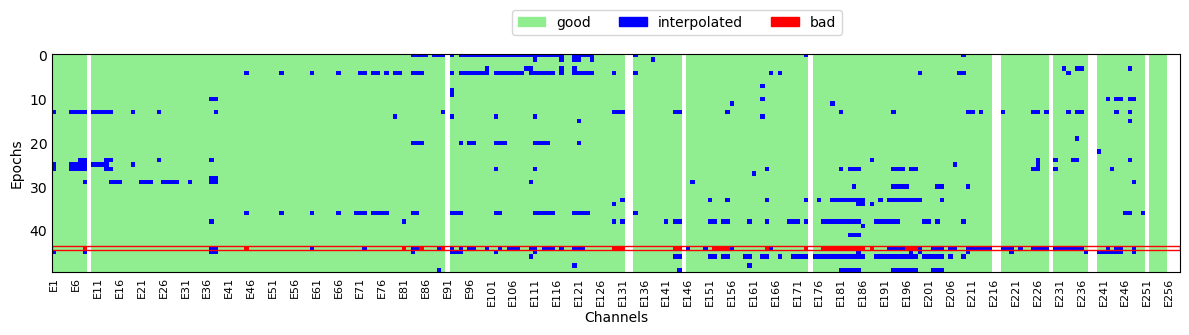

In [24]:
auto_reject_pre_ica = AutoReject(
    n_interpolate=[1, 2, 4, 8, 32, 64, 128],
    n_jobs=-1,
    random_state=100,
    thresh_method="bayesian_optimization",
    verbose=False,
    # n_interpolate=np.array([0]),
    # consensus=0.8,
).fit(epochs[:20])
print("fitting finished")
epochs_ar, reject_log = auto_reject_pre_ica.transform(epochs, return_log=True)


# depending of the resampling - different number of epochs are rejected

reject_plot = reject_log.plot("vertical")

# Save to eeglab


In [32]:
from eeglabio.utils import export_mne_epochs

eeglab_path = f"{
    project_path}/data/preproc/eeglab/"
Path(eeglab_path).mkdir(parents=True, exist_ok=True)
try:
    export_mne_epochs(epochs_ar, f"{
                  eeglab_path}/sub-{subject}_clean_epochs_ica-manual.set")
except Exception as e:
    print(e)

SyntaxError: expected 'except' or 'finally' block (693822164.py, line 9)

In [30]:
from specparam.plts.spectra import plot_spectra
from specparam import SpectralGroupModel


fg = SpectralGroupModel(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

# Specparam for non augmented data:


    Using multitaper spectrum estimation with 7 DPSS windows


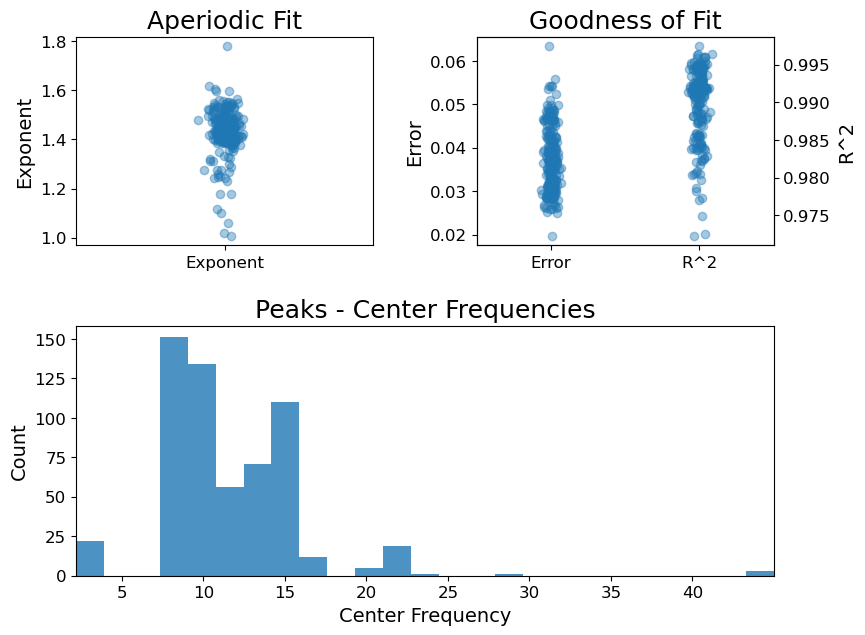

In [31]:
psd = epochs.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 45]
fg.fit(freqs, spectra, freq_range)
fg.plot()

# Specparam for augmented data


    Using multitaper spectrum estimation with 7 DPSS windows


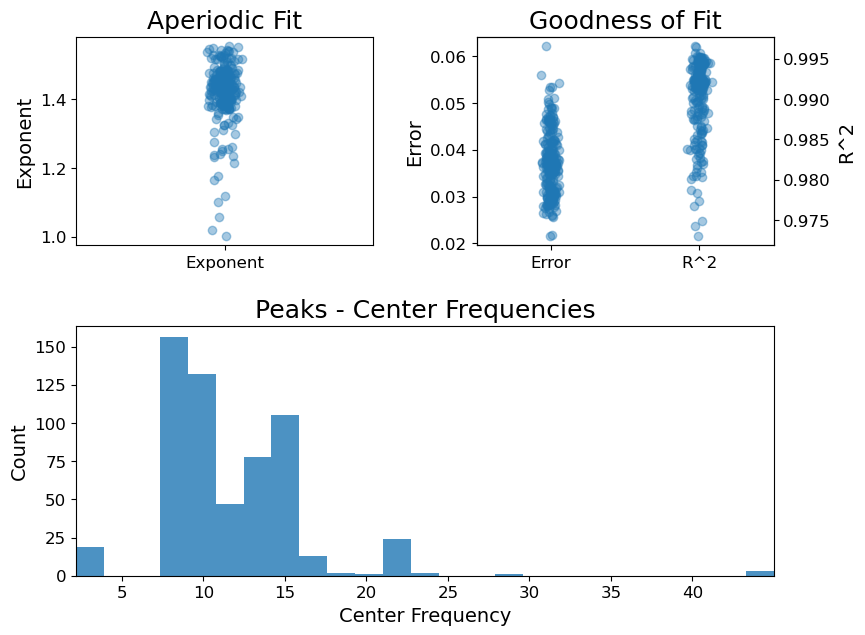

In [14]:
psd = epochs_ar.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 45]
fg.fit(freqs, spectra, freq_range)
fg.plot()

In [15]:
import pandas as pd
from specparam.core.funcs import infer_ap_func
from specparam.core.info import get_ap_indices

df = specparam2pandas(fg)
df.to_csv(f"{path_specparam}/sub-{subject}-specparam.csv", index=False)
print(f"Subject {subject} done")

Subject 101 done
